In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt


In [24]:
# 1. 加载数据
file_path = r'D:\Pythonworkshop\Solar_data_processing\cleaned_data_final_Yulara.csv'
data = pd.read_csv(file_path)

# 删除时间戳列
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])

# 添加前一时刻的功率数据作为新的特征
data['Prev_Power'] = data['Active_Power'].shift(1)
data['Prev_Power'] = data['Prev_Power'].fillna(0)  # 处理缺失值

# 数据集划分
X = data.drop(columns=['Active_Power'])
y = data['Active_Power']

# 假设 X 和 y 是你的特征和标签数据
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


# 使用训练集数据进行归一化
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 仅使用训练集数据拟合scaler
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# 使用训练集的归一化参数对验证集和测试集进行归一化
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

class LNNLayer(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(LNNLayer, self).__init__()
        self.hidden_size = hidden_size
        self.W_in = self.add_weight(
            shape=(input_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg),
            trainable=True
        )
        self.W_rec = self.add_weight(
            shape=(hidden_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg), 
            trainable=True
        )
        self.W_tau = self.add_weight(
            shape=(input_size + hidden_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg),
            trainable=True
        )
        self.activation = tf.nn.tanh
        self.tau_activation = tf.nn.softplus
        self.norm = layers.BatchNormalization()  # 添加归一化层

    def call(self, inputs, state):
        new_state = self.activation(tf.matmul(inputs, self.W_in) + tf.matmul(state, self.W_rec))
        combined = tf.concat([inputs, state], axis=-1)
        tau = self.tau_activation(tf.matmul(combined, self.W_tau))
        state = state + (1.0 / tau) * (new_state - state)
        state = self.norm(state)  # 归一化
        return state

class DynamicTimeConstantGRU(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(DynamicTimeConstantGRU, self).__init__()
        self.hidden_size = hidden_size
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_tau = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_tau = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.b_tau = self.add_weight(shape=(hidden_size,), initializer='zeros', trainable=True)
        self.activation = tf.nn.tanh
        self.sigmoid = tf.nn.sigmoid
        self.tau_activation = tf.nn.softplus
        self.norm = layers.BatchNormalization()  # 添加归一化层

    def call(self, inputs, state):
        r_t = self.sigmoid(tf.matmul(inputs, self.W_r) + tf.matmul(state, self.U_r))
        z_t = self.sigmoid(tf.matmul(inputs, self.W_z) + tf.matmul(state, self.U_z))
        h_tilde = self.activation(tf.matmul(inputs, self.W_h) + r_t * tf.matmul(state, self.U_h))
        tau_t = self.tau_activation(tf.matmul(inputs, self.W_tau) + tf.matmul(state, self.U_tau) + self.b_tau)
        new_state = state + (1.0 / tau_t) * (z_t * (h_tilde - state))
        new_state = self.norm(new_state)  # 归一化
        return new_state

class LNNGRUModelWithDropout(tf.keras.Model):
    def __init__(self, input_size, hidden_size_GRU, hidden_size_RNN, output_size, l2_reg, dropout_rate):
        super(LNNGRUModelWithDropout, self).__init__()
        self.lnn_layer = LNNLayer(input_size, hidden_size_RNN, l2_reg=l2_reg)
        self.dynamic_gru_layer = DynamicTimeConstantGRU(input_size, hidden_size_GRU, l2_reg=l2_reg)
        self.dropout = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(output_size, kernel_regularizer=regularizers.l2(l2_reg))

    def call(self, inputs):
        lnn_state = tf.zeros((tf.shape(inputs)[0], self.lnn_layer.hidden_size))
        lnn_output = self.lnn_layer(inputs, lnn_state)

        gru_state = tf.zeros((tf.shape(inputs)[0], self.dynamic_gru_layer.hidden_size))
        gru_output = self.dynamic_gru_layer(inputs, gru_state)

        combined_output = tf.concat([lnn_output, gru_output], axis=-1)
        dropped_output = self.dropout(combined_output)
        output = self.fc(dropped_output)
        return output
# 构建模型
input_size = X_train_scaled.shape[1]
hidden_size_GRU = 32
hidden_size_RNN = 128
l2_r = 0.0001
dropout_rate = 0.2
output_size = 1
TCLNNGRU_model =LNNGRUModelWithDropout(input_size, hidden_size_GRU, hidden_size_RNN, output_size,l2_r, dropout_rate)

# 编译模型
TCLNNGRU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0011910613648780674), loss='mse')

# 训练模型
TCLNNGRU_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, validation_data=(X_val_scaled, y_val_scaled))

# 测试模型
y_pred_lnn_scaled = TCLNNGRU_model.predict(X_test_scaled)
y_pred_lnn = scaler_y.inverse_transform(y_pred_lnn_scaled)

Epoch 1/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0458 - val_loss: 0.0166
Epoch 2/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0115 - val_loss: 0.0191
Epoch 3/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0111 - val_loss: 0.0150
Epoch 4/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0102 - val_loss: 0.0133
Epoch 5/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0101 - val_loss: 0.0150
Epoch 6/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0095 - val_loss: 0.0141
Epoch 7/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096 - val_loss: 0.0127
Epoch 8/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0091 - val_loss: 0.0119
Epoch 9/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089 - val_loss: 0.0128
Epoch 10/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - val_loss: 0.0139
Epoch 11/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086 - val_loss: 0.0139
Epoch 12/100
1142/1

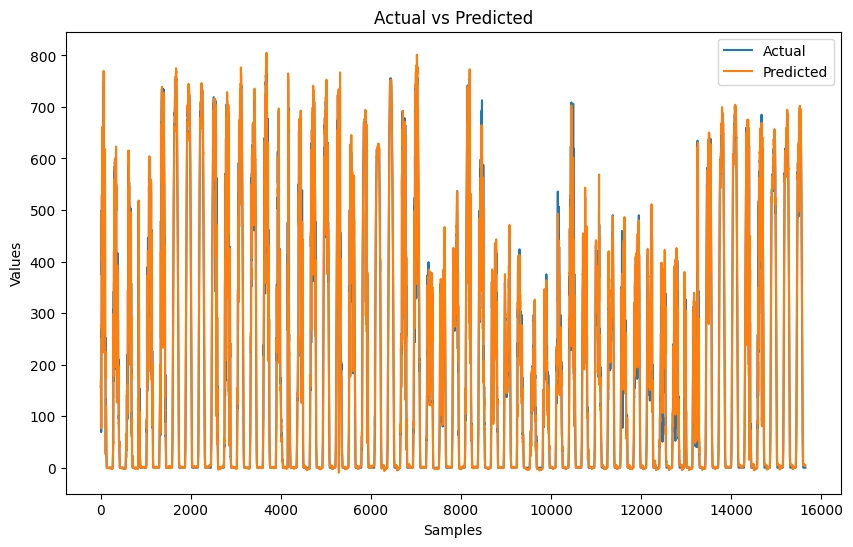

In [26]:
# 测试模型并反归一化
y_test = scaler_y.inverse_transform(y_test_scaled)

# 可视化预测结果与实际值对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_lnn, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred_lnn)
rmse = mean_squared_error(y_test, y_pred_lnn, squared=False)
r2 = r2_score(y_test, y_pred_lnn)
print("MAE: ", mae)
print("RMSE: ", rmse)
print("R2: ", r2)

MAE:  12.801234367911748
RMSE:  28.9890664039643
R2:  0.9839299061132107


c:\Users\bo.chen18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
